In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 
import random
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
class MIL_MNIST_Dataset:
    # Constructor for the MIL MNIST dataset class
    def __init__(self, num_bags, bag_size):
        # Initialize number of bags and bag size
        self.num_bags = num_bags
        self.bag_size = bag_size
        # Define transformation for converting data to tensor
        self.transform = transforms.ToTensor()
        # Load the MNIST dataset for training
        self.train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=self.transform)

    # Method to construct MIL MNIST dataset
    def construct_mil_mnist(self):
        # Initialize lists to store bag instances and labels
        mil_mnist_data = []
        mil_mnist_labels = []

        # Loop over the number of bags
        for _ in range(self.num_bags):
            # Randomly sample indices for creating a bag
            bag_indices = np.random.choice(len(self.train_dataset), size=self.bag_size, replace=False)
            # Stack instances corresponding to the sampled indices
            bag_instances = torch.stack([self.train_dataset[i][0] for i in bag_indices])
            # Extract labels for the instances in the bag
            bag_labels = torch.tensor([self.train_dataset[i][1] for i in bag_indices])

            # Determine the bag label based on the presence of label '1' in the bag
            if 1 in bag_labels:
                bag_label = 1
            else:
                bag_label = 0

            # Append bag instances and label to the lists
            mil_mnist_data.append(bag_instances)
            mil_mnist_labels.append(bag_label)

        # Convert lists to tensors and return
        return torch.stack(mil_mnist_data), torch.tensor(mil_mnist_labels)

# Example usage
num_bags = 1000
bag_size = 10
# Create an instance of MIL_MNIST_Dataset
mil_mnist_dataset = MIL_MNIST_Dataset(num_bags, bag_size)
# Construct MIL MNIST dataset
mil_mnist_data, mil_mnist_labels = mil_mnist_dataset.construct_mil_mnist()

## **<span style="color:red">Creating Filtered Datasets</span>**

We observed that the previous class generates datasets where all the bags contain the number 1 with an approximate probability close to 1, especially when the number of items per bag is set to 64. Hence, I have made a decision to introduce another dataset, termed as "filtered," which does not include the number 1.


In [3]:
class MIL_FILTERED_MNIST_Dataset:
    # Constructor for the filtered MIL MNIST dataset class
    def __init__(self, num_bags, bag_size):
        # Initialize number of bags and bag size
        self.num_bags = num_bags
        self.bag_size = bag_size
        # Define transformation for converting data to tensor
        self.transform = transforms.ToTensor()
        # Load the MNIST dataset for training
        self.train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=self.transform)

    # Method to create filtered MIL MNIST dataset
    def mil_mnist_data_filtered(self):
        # Define transformation for converting data to tensor
        transform = transforms.ToTensor()
        # Load the MNIST dataset for training
        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        # Filter out examples with label '1'
        train_dataset = [example for example in train_dataset if example[1] != 1]
        # Initialize lists to store bag instances and labels
        mil_mnist_data = []
        mil_mnist_labels = []

        # Loop over the number of bags
        for _ in range(self.num_bags):
            # Randomly sample indices for creating a bag
            bag_indices = np.random.choice(len(train_dataset), size=self.bag_size, replace=False)
            # Stack instances corresponding to the sampled indices
            bag_instances = torch.stack([train_dataset[i][0] for i in bag_indices])
            # Assign label '0' to all instances in the bag
            bag_label = 0
            # Append bag instances and label to the lists
            mil_mnist_data.append(bag_instances)
            mil_mnist_labels.append(bag_label)

        # Convert lists to tensors and return
        return torch.stack(mil_mnist_data), torch.tensor(mil_mnist_labels)


In [4]:
def stacking_data_base(data1, data2):
    """
    Function to stack two tensors along the first dimension.

    Args:
    - data1: First tensor to be stacked
    - data2: Second tensor to be stacked

    Returns:
    - Stacked tensor containing data from both input tensors
    """
    # Concatenate data1 and data2 along the first dimension
    stacked_data = torch.cat((data1, data2))
    return stacked_data


The label of this bag is 1
element 1 of the bag :


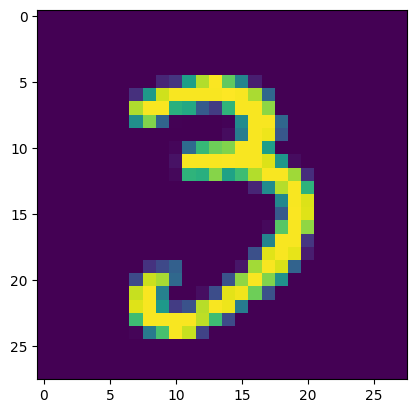

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
element 2 of the bag :


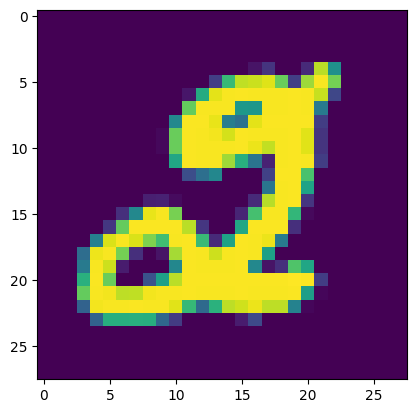

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
element 3 of the bag :


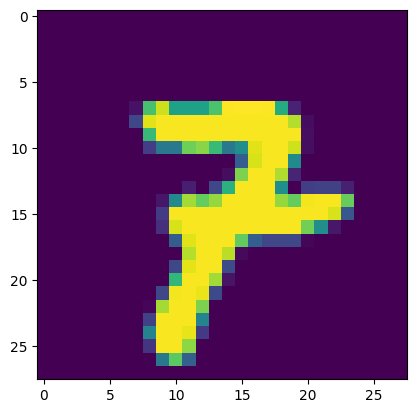

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
element 4 of the bag :


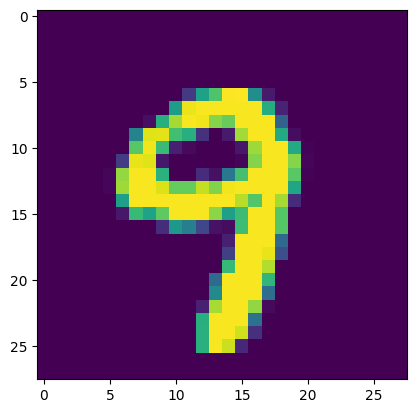

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
element 5 of the bag :


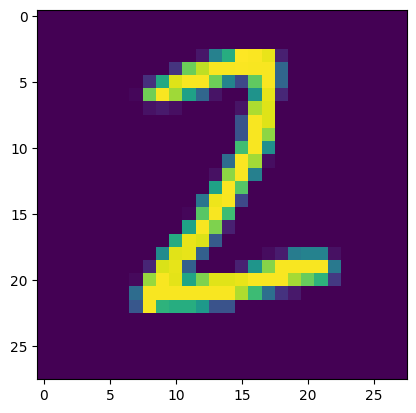

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
element 6 of the bag :


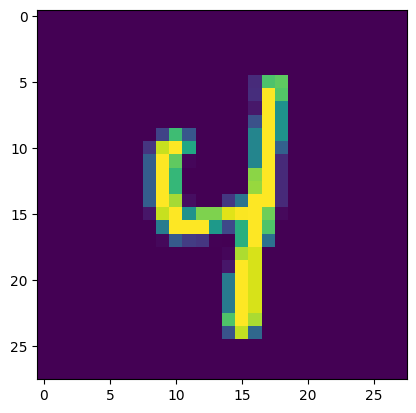

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
element 7 of the bag :


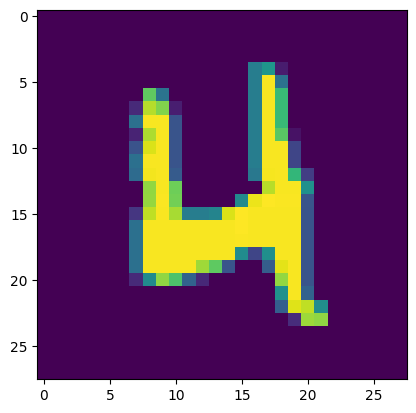

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
element 8 of the bag :


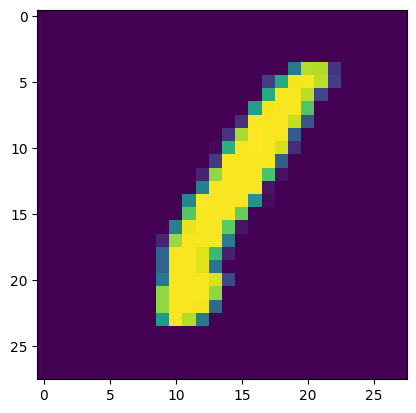

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
element 9 of the bag :


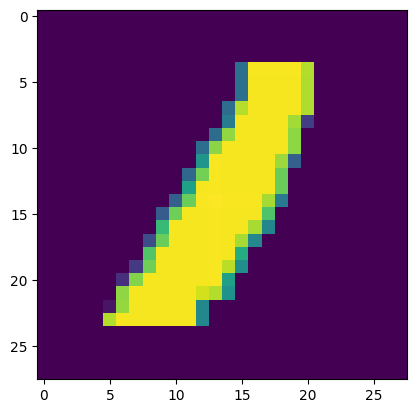

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
element 10 of the bag :


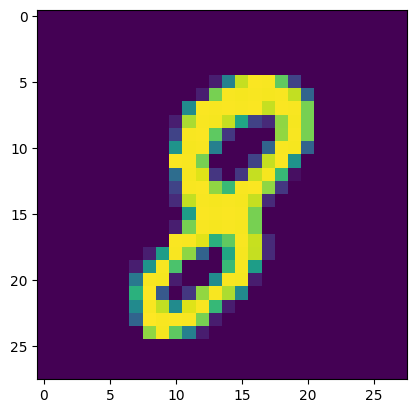

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [5]:
# Plotting the elements of a bag and presenting the label of the bag
random_bag = random.randint(0,num_bags)
bag_plotted, label_bag_plotted = mil_mnist_data[random_bag], mil_mnist_labels[random_bag]
print(f"The label of this bag is {label_bag_plotted}")
print(f"=================================================")

i = 1
for image in bag_plotted:
    print(f"element {i} of the bag :")
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()
    i += 1
    print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


In [6]:
# Define parameters
bag_length = 64
num_bags_train = 100
num_bags_test = 50
image_size = 28*28

# Calculate proportions of normal and filtered bags for training and testing
proportion_train = random.randint(0,num_bags_train) / num_bags_train
proportion_test = random.randint(0,num_bags_test) / num_bags_test
num_bags_train_normal = int(num_bags_train*proportion_train)
num_bags_train_filtered = num_bags_train - num_bags_train_normal
num_bags_test_normal = int(num_bags_test*proportion_test)
num_bags_test_filtered = num_bags_test - num_bags_test_normal

# Create MIL MNIST datasets for training
mil_train_dataset1 = MIL_MNIST_Dataset(num_bags_train_normal, bag_length)
mil_train_data1, mil_train_labels1 = mil_train_dataset1.construct_mil_mnist()

# Create filtered MIL MNIST dataset for training
mil_filtered_dataset = MIL_FILTERED_MNIST_Dataset(num_bags_train_filtered, bag_length)
mil_train_data_filtered, mil_train_labels_filtered = mil_filtered_dataset.mil_mnist_data_filtered()

# Stack data from normal and filtered datasets for training
mil_train_data, mil_train_labels = stacking_data_base(mil_train_data1, mil_train_data_filtered), stacking_data_base(mil_train_labels1, mil_train_labels_filtered) 

# Create MIL MNIST datasets for testing
mil_test_dataset1 = MIL_MNIST_Dataset(num_bags_test_normal, bag_length)
mil_test_data1, mil_test_labels1 = mil_test_dataset1.construct_mil_mnist()

# Create filtered MIL MNIST dataset for testing
mil_filtered_dataset = MIL_FILTERED_MNIST_Dataset(num_bags_test_filtered, bag_length)
mil_test_data_filtered, mil_test_labels_filtered = mil_filtered_dataset.mil_mnist_data_filtered()

# Stack data from normal and filtered datasets for testing
mil_test_data, mil_test_labels = stacking_data_base(mil_test_data1, mil_test_data_filtered), stacking_data_base(mil_test_labels1, mil_test_labels_filtered)

# Create PyTorch TensorDataset objects for training and testing
dataset_train = TensorDataset(mil_train_data, mil_train_labels)
dataset_test = TensorDataset(mil_test_data, mil_test_labels)

# Optionally, create DataLoader objects for batch processing during training
train_loader = DataLoader(dataset_train, shuffle=True)
test_loader = DataLoader(dataset_test, shuffle=False)


In [22]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()

        self.fc1 = nn.Linear(28 * 28 , 128)
        self.fc2 = nn.Linear(128 , 64)
        self.fc3 = nn.Linear(64 , 32)
        self.fc4 = nn.Linear(32 , 16)
        self.fc5 = nn.Linear(16 , 1)

    
    def forward(self, x):
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))

        return x


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print('GPU brrr')

GPU brrr


In [25]:
# Instantiate the SimpleNN model
model = SimpleNN().to(device)

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Define the number of epochs
epochs = 20

training_loss = []

# Loop over each epoch
for epoch in tqdm(range(epochs)):
    
    # Loop over each bag in the training loader
    for bag in train_loader:
        # Extract the label for the bag
        label_bag = bag[1] 
        
        # Loop over each instance in the bag
        for i in range(bag_length):
            # Extract the instance and move it to the appropriate device
            el = torch.tensor(bag[0][0][i].view(1, image_size), device=device)
            
            # Reset the gradients
            optimizer.zero_grad()
            
            # Forward pass: compute predicted outputs by passing the instance through the model
            out = model(el)
            
            # Calculate the loss
            output = out.view(-1).to(device)
            target = label_bag.type(torch.float).to(device) 

            loss = criterion(output, target)
            
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Adding loss to training_loss
            training_loss.append(loss.item())
            
            # Update the parameters
            optimizer.step()


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\Mrabe\AppData\Local\Temp\ipykernel_22440\625631568.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  el = torch.tensor(bag[0][0][i].view(1, image_size), device=device)


In [26]:
# Computing accuracy on training set

correct_train = 0
total_train = num_bags_train
treshold = 0.5

# Set model to evaluation mode
model.eval()

model = model.to(torch.device('cpu'))

# Iterate over the test data
truth = []
pred = []
for bag, label in train_loader:
    bag = bag.view(-1, image_size)
    outputs = model(bag)
    predicted = torch.mean(outputs) > treshold
    pred.append(predicted)
    truth.append(label.item())
    correct_train += (predicted == label)

# Calculate accuracy
accuracy_train = correct_train / num_bags_train


# Computing accuracy on test set

correct = 0
total = num_bags_test
treshold = 0.5

# Set model to evaluation mode
model.eval()

# Iterate over the test data
truth = []
pred = []

for bag, label in test_loader:
    bag = bag.view(-1, image_size)
    outputs = model(bag)
    predicted = torch.mean(outputs) > treshold
    pred.append(predicted)
    truth.append(label.item())
    correct += (predicted == label)

# Calculate accuracy
accuracy = correct / num_bags_test






print("Training set : ")
print(f'Accuracy on the training set: {accuracy_train.item()}')

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

print("Test set : ")
print(f'Accuracy on the test set: {accuracy.item()}')



Training set : 
Accuracy on the training set: 0.4099999964237213
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test set : 
Accuracy on the test set: 0.3199999928474426


[[ 0 34]
 [ 0 16]]


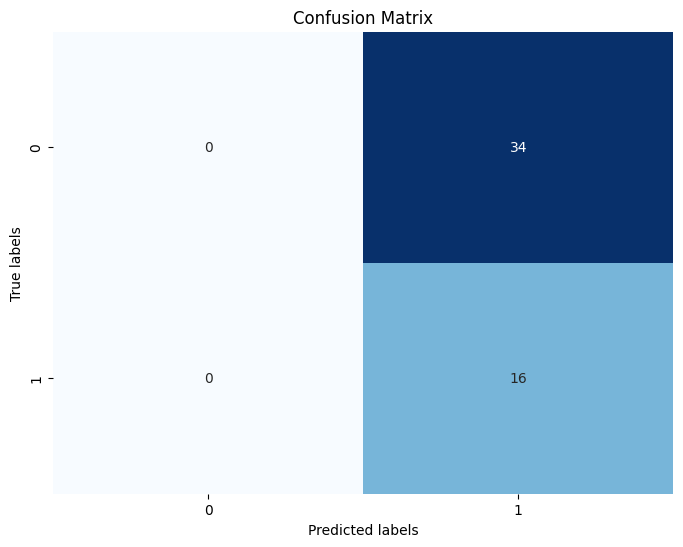

In [27]:
# Confusion matrix with treshold 0.5

conf_matrix = confusion_matrix(truth, pred)
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

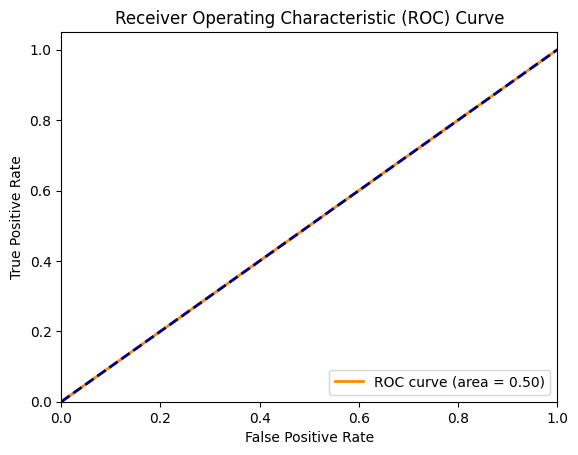

In [ ]:
# Assuming model is your neural network model and test_loader is your DataLoader for testing data
model.eval()
y_true = []
y_scores = []



for bag, label in test_loader:
    bag = bag.view(-1, image_size)
    outputs = model(bag)
    y_scores.append(torch.mean(outputs).item())
    y_true.append(label.item())


fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
